 # 1. Import and Install Dependencies

In [ ]:
# !pip install tensorflow==2.16.1 opencv-python mediapipe scikit-learn matplotlib keras==3.0

In [1]:
import cv2
import numpy as np
import os
from matplotlib import pyplot as plt
import time
import mediapipe as mp

2024-04-29 08:49:44.346383: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-04-29 08:49:45.268413: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


# 2. Keypoints using MP Holistic

In [2]:
mp_holistic = mp.solutions.holistic # Holistic model
mp_drawing = mp.solutions.drawing_utils # Drawing utilities

In [3]:
def mediapipe_detection(image, model):
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) # COLOR CONVERSION BGR 2 RGB
    image.flags.writeable = False                  # Image is no longer writeable
    results = model.process(image)                 # Make prediction
    image.flags.writeable = True                   # Image is now writeable 
    image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR) # COLOR COVERSION RGB 2 BGR
    return image, results

In [4]:
def draw_landmarks(image, results):
    mp_drawing.draw_landmarks(image, results.face_landmarks, mp_holistic.FACEMESH_TESSELATION) # Draw face connections
    mp_drawing.draw_landmarks(image, results.pose_landmarks, mp_holistic.POSE_CONNECTIONS) # Draw pose connections
    mp_drawing.draw_landmarks(image, results.left_hand_landmarks, mp_holistic.HAND_CONNECTIONS) # Draw left hand connections
    mp_drawing.draw_landmarks(image, results.right_hand_landmarks, mp_holistic.HAND_CONNECTIONS) # Draw right hand connections

In [5]:
def draw_styled_landmarks(image, results):
    # Draw face connections
    mp_drawing.draw_landmarks(image, results.face_landmarks, mp_holistic.FACEMESH_TESSELATION, 
                             mp_drawing.DrawingSpec(color=(80,110,10), thickness=1, circle_radius=1), 
                             mp_drawing.DrawingSpec(color=(80,256,121), thickness=1, circle_radius=1)
                             ) 
    # Draw pose connections
    mp_drawing.draw_landmarks(image, results.pose_landmarks, mp_holistic.POSE_CONNECTIONS,
                             mp_drawing.DrawingSpec(color=(80,22,10), thickness=2, circle_radius=4), 
                             mp_drawing.DrawingSpec(color=(80,44,121), thickness=2, circle_radius=2)
                             ) 
    # Draw left hand connections
    mp_drawing.draw_landmarks(image, results.left_hand_landmarks, mp_holistic.HAND_CONNECTIONS, 
                             mp_drawing.DrawingSpec(color=(121,22,76), thickness=2, circle_radius=4), 
                             mp_drawing.DrawingSpec(color=(121,44,250), thickness=2, circle_radius=2)
                             ) 
    # Draw right hand connections  
    mp_drawing.draw_landmarks(image, results.right_hand_landmarks, mp_holistic.HAND_CONNECTIONS, 
                             mp_drawing.DrawingSpec(color=(245,117,66), thickness=2, circle_radius=4), 
                             mp_drawing.DrawingSpec(color=(245,66,230), thickness=2, circle_radius=2)
                             ) 

In [6]:
cap = cv2.VideoCapture(0)
# Set mediapipe model 
with mp_holistic.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5) as holistic:
    while cap.isOpened():

        # Read feed
        ret, frame = cap.read()

        # Mirror the frame
        frame = cv2.flip(frame, 1)

        # Make detections
        image, results = mediapipe_detection(frame, holistic)
        print(results)
        
        # Draw landmarks
        draw_styled_landmarks(image, results)

        # Show to screen
        cv2.imshow('OpenCV Feed', image)

        # Break gracefully
        if cv2.waitKey(10) & 0xFF == ord('q'):
            break
        cap.release()
        cv2.destroyAllWindows()

I0000 00:00:1714327857.209491   10628 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1714327857.212967   10719 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 Mesa 24.0.3-1pop1~1711635559~22.04~7a9f319), renderer: AMD Radeon Graphics (radeonsi, renoir, LLVM 15.0.7, DRM 3.57, 6.8.0-76060800daily20240311-generic)
INFO: Created TensorFlow Lite XNNPACK delegate for CPU.


<class 'mediapipe.python.solution_base.SolutionOutputs'>


In [7]:
draw_landmarks(frame, results)

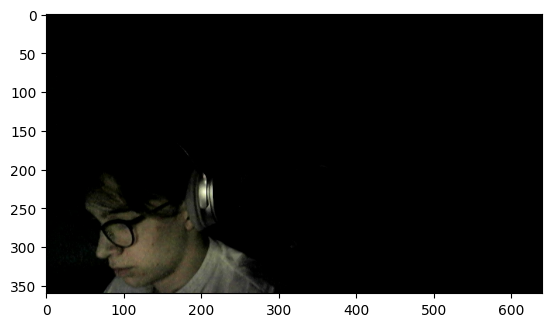

In [8]:
plt.imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))

# 3. Extract Keypoint Values

In [9]:
if results.left_hand_landmarks is not None:
    len(results.left_hand_landmarks.landmark)
else:
    print("No left hand detected.")

No left hand detected.


In [10]:
pose = []
for res in results.pose_landmarks.landmark:
    test = np.array([res.x, res.y, res.z, res.visibility])
    pose.append(test)

AttributeError: 'NoneType' object has no attribute 'landmark'

In [ ]:
pose = np.array([[res.x, res.y, res.z, res.visibility] for res in results.pose_landmarks.landmark]).flatten() if results.pose_landmarks else np.zeros(132)
face = np.array([[res.x, res.y, res.z] for res in results.face_landmarks.landmark]).flatten() if results.face_landmarks else np.zeros(1404)
lh = np.array([[res.x, res.y, res.z] for res in results.left_hand_landmarks.landmark]).flatten() if results.left_hand_landmarks else np.zeros(21*3)
rh = np.array([[res.x, res.y, res.z] for res in results.right_hand_landmarks.landmark]).flatten() if results.right_hand_landmarks else np.zeros(21*3)

In [ ]:
if results.face_landmarks:
    face = np.array([[res.x, res.y, res.z] for res in results.face_landmarks.landmark]).flatten() 
else:
    np.zeros(1404)


In [ ]:
def extract_keypoints(results):
    pose = np.array([[res.x, res.y, res.z, res.visibility] for res in results.pose_landmarks.landmark]).flatten() if results.pose_landmarks else np.zeros(33*4)
    face = np.array([[res.x, res.y, res.z] for res in results.face_landmarks.landmark]).flatten() if results.face_landmarks else np.zeros(468*3)
    lh = np.array([[res.x, res.y, res.z] for res in results.left_hand_landmarks.landmark]).flatten() if results.left_hand_landmarks else np.zeros(21*3)
    rh = np.array([[res.x, res.y, res.z] for res in results.right_hand_landmarks.landmark]).flatten() if results.right_hand_landmarks else np.zeros(21*3)
    return np.concatenate([pose, face, lh, rh])

In [ ]:
result_test = extract_keypoints(results)

In [ ]:
result_test

In [ ]:
np.save('0', result_test)

In [ ]:
np.load('0.npy')

# 4. Setup Folders for Collection

In [2]:
# Path for exported data, numpy arrays
DATA_PATH = os.path.join('CollectionBase/MP_Data') 

# Actions that we try to detect
actions = np.array(['wave', 'thankyou', 'noice']) ##### HERE YOU CAN CHANGE THE ACTIONS

# 30 sequences worth of data
no_sequences = 30

# Each sequence 30 frames in length
sequence_length = 30

# Folder start
start_folder = 0

In [ ]:
for action in actions: 
    #dir_path = os.path.join(DATA_PATH, action)
   # if not os.path.exists(dir_path):
    #    os.makedirs(dir_path)
        
    # dirmax = np.max(np.array(os.listdir(os.path.join(DATA_PATH, action))).astype(int))
    for sequence in range(no_sequences):
        try: 
            os.makedirs(os.path.join(DATA_PATH, action, str(sequence))) #was str(dirmax + sequence)
        except:
            pass

# 5. Collect Keypoint Values for Training and Testing

In [ ]:
import time

cap = cv2.VideoCapture(1)

# Set mediapipe model 
with mp_holistic.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5) as holistic:
    # Loop through actions
    for action in actions:
        # Loop through sequences aka videos
        for sequence in range(start_folder, start_folder+no_sequences):
            while True:
                ret, frame = cap.read()
               # frame = cv2.flip(frame,1)
                # Make detections
                image, results = mediapipe_detection(frame, holistic)

                # Draw landmarks
                draw_styled_landmarks(image, results)

                cv2.imshow('OpenCV Feed', image)
                key = cv2.waitKey(10) & 0xFF
                if key == ord('g'):
                    break
                elif key == ord('h'):
                    for i in range(3, 0, -1):
                        ret, frame = cap.read()

                        # Make detections
                        image, results = mediapipe_detection(frame, holistic)

                        # Draw landmarks
                        draw_styled_landmarks(image, results)

                        cv2.putText(image, 'Starting in {}'.format(i), (120,200), 
                                    cv2.FONT_HERSHEY_SIMPLEX, 1, (0,255, 0), 4, cv2.LINE_AA)
                        cv2.imshow('OpenCV Feed', image)
                        cv2.waitKey(1000)
                    break
                elif key == ord('q'):
                    break_flag = True
                    break

            if 'break_flag' in locals() and break_flag:
                break

            # Loop through video length aka sequence length
            for frame_num in range(sequence_length):
                ret, frame = cap.read()
              #  frame = cv2.flip(frame,1)
                image, results = mediapipe_detection(frame, holistic)
                draw_styled_landmarks(image, results)
                
                #Wait
                if frame_num == 0: 
                    cv2.putText(image, 'STARTING COLLECTION', (120,200), 
                               cv2.FONT_HERSHEY_SIMPLEX, 1, (0,255, 0), 4, cv2.LINE_AA)
                    cv2.putText(image, 'Collecting frames for {} Sequence Number {}'.format(action, sequence), (15,12), 
                               cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 255), 1, cv2.LINE_AA)
                    # Show to screen
                    cv2.imshow('OpenCV Feed', image)
                    cv2.waitKey(500)
                else: 
                    cv2.putText(image, 'Collecting frames for {} Sequence Number {}'.format(action, sequence), (15,12), 
                               cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 255), 1, cv2.LINE_AA)
                    # Show to screen
                    cv2.imshow('OpenCV Feed', image)
                
                # Display current frame number (DOESN'T WORK) Idc though
                cv2.putText(image, 'Frame: {}'.format(frame_num), (frame.shape[1] - 120, 12), 
                            cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 255), 1, cv2.LINE_AA)

                # Export keypoints
                keypoints = extract_keypoints(results)
                npy_path = os.path.join(DATA_PATH, action, str(sequence), str(frame_num))
                np.save(npy_path, keypoints)

                # Break gracefully
                if cv2.waitKey(10) & 0xFF == ord('q'):
                    break

    cap.release()
    cv2.destroyAllWindows()
    

In [ ]:
cap.release()
cv2.destroyAllWindows()

# 5.1 TESTING

In [ ]:
import cv2
import numpy as np
keypoints = np.load('9.npy') #CHANGE NAME HERE IF YOU WANT TO TEST

image = np.zeros((480, 640, 3), dtype=np.uint8)

num_pose_keypoints = 33
num_face_keypoints = 468
num_hand_keypoints = 21

pose_keypoints = keypoints[:num_pose_keypoints*4].reshape((-1, 4))
face_keypoints = keypoints[num_pose_keypoints*4:num_pose_keypoints*4+num_face_keypoints*3].reshape((-1, 3))
lh_keypoints = keypoints[num_pose_keypoints*4+num_face_keypoints*3:num_pose_keypoints*4+num_face_keypoints*3+num_hand_keypoints*3].reshape((-1, 3))
rh_keypoints = keypoints[num_pose_keypoints*4+num_face_keypoints*3+num_hand_keypoints*3:].reshape((-1, 3))

for keypoints in [pose_keypoints, face_keypoints, lh_keypoints, rh_keypoints]:
    for x, y, z in keypoints[:,:3]:
        cv2.circle(image, (int(x*640), int(y*480)), 5, (0, 255, 0), -1)

cv2.imshow('Keypoints', image)
cv2.waitKey(0)
cv2.destroyAllWindows()

# 6. Preprocess Data and Create Labels and Features

In [3]:
from sklearn.model_selection import train_test_split 
from tensorflow.keras.utils import to_categorical


In [4]:
label_map = {label:num for num, label in enumerate(actions)}

In [5]:
label_map

{'wave': 0, 'thankyou': 1, 'noice': 2}

In [6]:
sequences, labels = [], []
print(os.getcwd())
for action in actions:
    for sequence in np.array(os.listdir(os.path.join(DATA_PATH, action))).astype(int):
        window = []
        for frame_num in range(sequence_length):
            res = np.load(os.path.join(DATA_PATH, action, str(sequence), "{}.npy".format(frame_num)))
            window.append(res)
        sequences.append(window)
        labels.append(label_map[action])

/home/eelam/Desktop/AI/attempt2/AiSignLanguage


In [7]:
np.array(sequences).shape

(90, 30, 1662)

In [8]:
np.array(labels).shape

(90,)

In [9]:
X = np.array(sequences)

In [10]:
X.shape

(90, 30, 1662)

In [11]:
y = to_categorical(labels).astype(int)

In [12]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.05)

In [13]:
y_test.shape

(5, 3)

# 7. Build and Train LSTM Neural Network

In [14]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.callbacks import TensorBoard

In [15]:
log_dir = os.path.join('CollectionBase/Logs')
tb_callback = TensorBoard(log_dir=log_dir)

In [16]:
model = Sequential()
model.add(LSTM(64, return_sequences=True, activation='relu', input_shape=(30,1662)))
model.add(LSTM(128, return_sequences=True, activation='relu'))
model.add(LSTM(64, return_sequences=False, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(actions.shape[0], activation='softmax'))

2024-04-29 08:49:48.304589: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-04-29 08:49:48.313725: W tensorflow/core/common_runtime/gpu/gpu_device.cc:2251] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...
/home/eelam/.local/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  supe

In [17]:
model.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=['categorical_accuracy'])

In [18]:
model.fit(X_train, y_train, epochs=2000, callbacks=[tb_callback])

Epoch 1/2000
3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 41ms/step - categorical_accuracy: 0.3502 - loss: 2.3581
Epoch 2/2000
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - categorical_accuracy: 0.3463 - loss: 9.4616
Epoch 3/2000
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - categorical_accuracy: 0.3619 - loss: 19.0057
Epoch 4/2000
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - categorical_accuracy: 0.3580 - loss: 12.6199
Epoch 5/2000
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - categorical_accuracy: 0.3268 - loss: 12.5982
Epoch 6/2000
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - categorical_accuracy: 0.2681 - loss: 18.2057
Epoch 7/2000
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - categorical_accuracy: 0.2838 - loss: 31.3232
Epoch 8/2000
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - categorical_accuracy: 0.2407 - loss: 42.3519
Epoch 9/2000
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - categorical_accuracy: 0.4422 - loss: 14.2864
Epoch 10/2000
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - categorical_accuracy: 0.2877 - loss: 16.6219
Epoch 11/2000
3/3 ━━━

In [19]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape              ┃    Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 30, 64)            │    442,112 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ lstm_1 (LSTM)                   │ (None, 30, 128)           │     98,816 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ lstm_2 (LSTM)                   │ (None, 64)                │     49,408 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ dense (Dense)                   │ (None, 64)                │      4,160 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ dense_1 (Dense)                 │ (None, 32)                │      2,080 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ dense_2 (Dense)                 │ (None, 3)                 │         99 │
└─────────────────────────────────┴───────────────────────────┴────────────┘

 Total params: 1,790,027 (6.83 MB)

 Trainable params: 596,675 (2.28 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 1,193,352 (4.55 MB)

# 8. Make Predictions

In [20]:
res = model.predict(X_test)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 322ms/step


In [21]:
actions[np.argmax(res[4])]

'thankyou'

In [22]:
actions[np.argmax(y_test[4])]

'noice'

# 9. Save Weights

In [23]:
model.save('action2.keras')

In [24]:
del model

In [25]:
model = Sequential()
model.add(LSTM(64, return_sequences=True, activation='relu', input_shape=(30,1662)))
model.add(LSTM(128, return_sequences=True, activation='relu'))
model.add(LSTM(64, return_sequences=False, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(actions.shape[0], activation='softmax'))
model.load_weights('action2.keras')

# 10. Evaluation using Confusion Matrix and Accuracy

In [26]:
from sklearn.metrics import multilabel_confusion_matrix, accuracy_score

In [27]:
yhat = model.predict(X_test)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 272ms/step


In [28]:
ytrue = np.argmax(y_test, axis=1).tolist()
yhat = np.argmax(yhat, axis=1).tolist()

In [29]:
multilabel_confusion_matrix(ytrue, yhat)

array([[[4, 1],
        [0, 0]],

       [[2, 1],
        [0, 2]],

       [[2, 0],
        [2, 1]]])

In [30]:
accuracy_score(ytrue, yhat)

0.6

# 11. Test in Real Time

In [157]:
from scipy import stats

In [158]:
colors = [(245,117,16), (117,245,16), (16,117,245)]
def prob_viz(res, actions, input_frame, colors):
    output_frame = input_frame.copy()
    for num, prob in enumerate(res):
        cv2.rectangle(output_frame, (0,60+num*40), (int(prob*100), 90+num*40), colors[num], -1)
        cv2.putText(output_frame, actions[num], (0, 85+num*40), cv2.FONT_HERSHEY_SIMPLEX, 1, (255,255,255), 2, cv2.LINE_AA)
        
    return output_frame

In [159]:
cap = cv2.VideoCapture(0)  # Start the webcam
ret, image = cap.read()  # Read a frame from the webcam
cap.release()  # Close the webcam

plt.figure(figsize=(18,18))
plt.imshow(prob_viz(res, actions, image, colors))

TypeError: only length-1 arrays can be converted to Python scalars

<Figure size 1800x1800 with 0 Axes>

In [ ]:
# 1. New detection variables
sequence = []
sentence = []
predictions = []
threshold = 0.5

cap = cv2.VideoCapture(0)
# Set mediapipe model 
with mp_holistic.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5) as holistic:
    while cap.isOpened():

        # Read feed
        ret, frame = cap.read()

        # Make detections
        image, results = mediapipe_detection(frame, holistic)
        print(results)
        
        # Draw landmarks
        draw_styled_landmarks(image, results)
        
        # 2. Prediction logic
        keypoints = extract_keypoints(results)
        sequence.append(keypoints)
        sequence = sequence[-30:]
        
        if len(sequence) == 30:
            res = model.predict(np.expand_dims(sequence, axis=0))[0]
            print(actions[np.argmax(res)])
            predictions.append(np.argmax(res))
            
            
        #3. Viz logic
            if np.unique(predictions[-10:])[0]==np.argmax(res): 
                if res[np.argmax(res)] > threshold: 
                    
                    if len(sentence) > 0: 
                        if actions[np.argmax(res)] != sentence[-1]:
                            sentence.append(actions[np.argmax(res)])
                    else:
                        sentence.append(actions[np.argmax(res)])

            if len(sentence) > 5: 
                sentence = sentence[-5:]

            # Viz probabilities
            image = prob_viz(res, actions, image, colors)
            
        cv2.rectangle(image, (0,0), (640, 40), (245, 117, 16), -1)
        cv2.putText(image, ' '.join(sentence), (3,30), 
                       cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2, cv2.LINE_AA)
        
        # Show to screen
        cv2.imshow('OpenCV Feed', image)

        # Break gracefully
        if cv2.waitKey(10) & 0xFF == ord('q'):
            break
    cap.release()
    cv2.destroyAllWindows()